In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
from lib import User, Movie, Recommender
import matplotlib.pylab as plt
import math
import numpy as np

In [2]:
rec = Recommender(lam=0.01, gamma=0.01, tau=0.01)
rec.initialize_from_csv("ml-25m/movies.csv", "ml-25m/ratings.csv")
print(len(rec.users))
print(len(rec.movies))

Initialized
Parsed ml-25m/ratings.csv
Parsed ml-25m/movies.csv


Reformatting movie ratings: 100%|██████████| 59047/59047 [00:24<00:00, 2411.43it/s] 

162541
59047


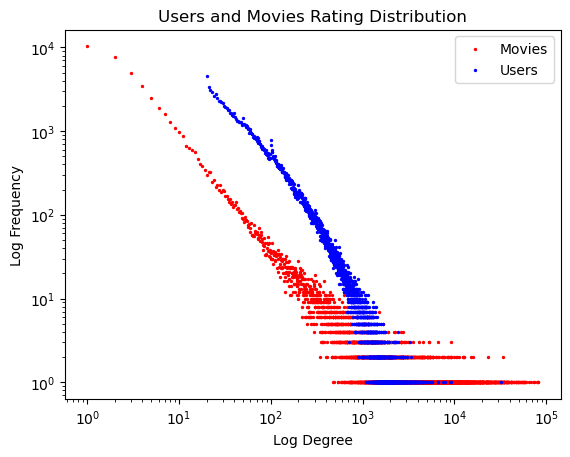

In [3]:
user_freq = {}
movie_freq = {}

#iterate over users
for user in rec.users:
    degree = len(user.ratings)
    if degree not in user_freq:
        user_freq[degree] = 1
    else:
        user_freq[degree] += 1

for movie in rec.movies:
    degree = len(movie.ratings)

    if degree not in movie_freq:
        movie_freq[degree] = 1
    else:
        movie_freq[degree] += 1

m_deg = [degree for degree in movie_freq.keys()]
m_freq = [freq for freq in movie_freq.values()]
plt.scatter(m_deg, m_freq, c='red', s=2, label='Movies')

u_deg = [degree for degree in user_freq.keys()]
u_freq = [freq for freq in user_freq.values()]
plt.scatter(u_deg, u_freq, c='blue', s=2, label='Users')
plt.xscale("log")
plt.yscale("log")


plt.xlabel("Log Degree")
plt.ylabel("Log Frequency")
plt.legend()
plt.title("Users and Movies Rating Distribution")

plt.show()

In [4]:
statistics = rec.fit_vectorized(max_iter=10)

100%|██████████| 10/10 [55:45<00:00, 334.52s/it]


[1709012.0986855652, 111886.8914247614, 88736.6493149089, 79275.45826898374, 73062.39906357357, 69870.17692108096, 68114.44062523285, 67004.27132505, 66215.48015641473, 65610.73169391781, 65124.56843038508, 64721.132568481036]


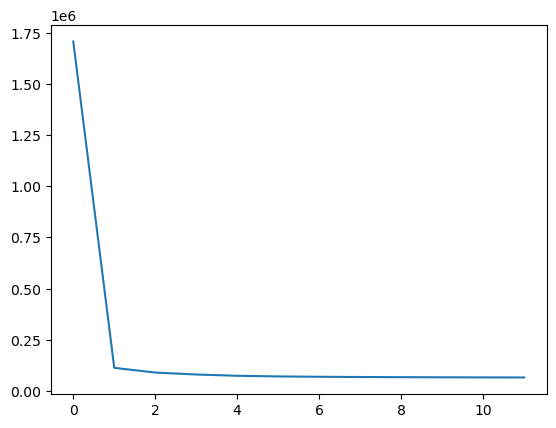

In [5]:
plt.plot(statistics['neg_log_liks'])
print(statistics['neg_log_liks'])

[3.696374689077907, 0.8940759802147795, 0.7798057914471099, 0.7312031992794279, 0.6988155122251883, 0.6823375081376459, 0.6737268002218294, 0.6686833524448514, 0.665399804615993, 0.663103787695158, 0.6614279964246954, 0.6601723142009792]


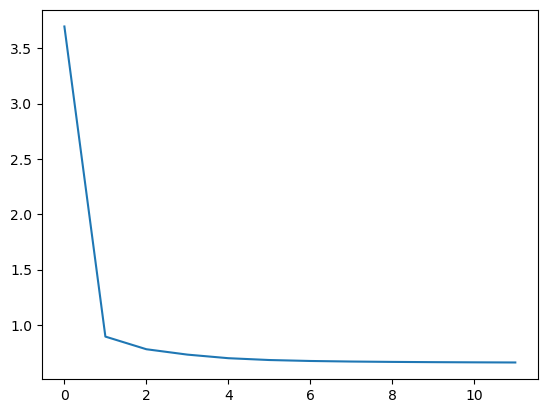

In [6]:
plt.plot(statistics['RMSEs'])
print(statistics['RMSEs'])

[0.9990784173308594, 0.9990784173308594, 2.3586979037353926, 2.36471345202914, 2.355072827446279, 2.3515507785891705, 2.343344838549216, 2.3323659218512547, 2.3202964737770344, 2.308471574050272, 2.2974275449240205, 2.28738585737067]


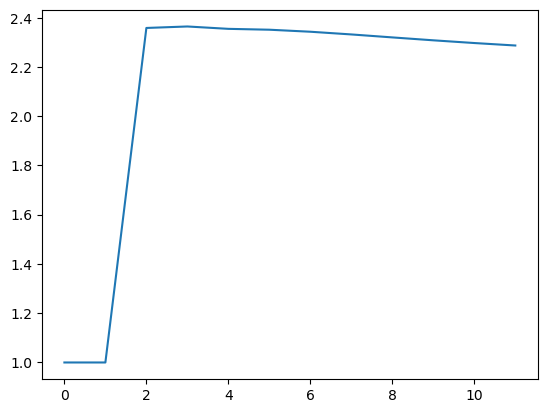

In [7]:
plt.plot(statistics['user_embed_length'])
print(statistics['user_embed_length'])

[1.0006347152579853, 1.0006347152579853, 1.1720396600650564, 1.4766937203780186, 1.560182217914224, 1.6150622287462142, 1.662865036957703, 1.7073250966810878, 1.7495007953482204, 1.7895447176691845, 1.8276309343128236, 1.8638936495417169]


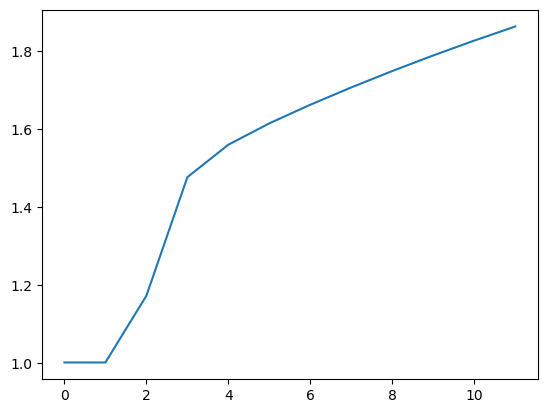

In [8]:
plt.plot(statistics['item_embed_length'])
print(statistics['item_embed_length'])

[0.0, 3.6138911859350697, 3.547496428098701, 3.482911256840118, 3.4050022093505037, 3.339494227405758, 3.283073751735026, 3.232153754630822, 3.1848852692657554, 3.1403197872901587, 3.0979273182888734, 3.057373889368677]


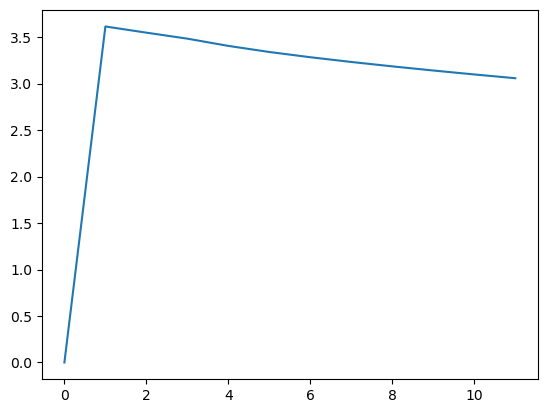

In [9]:
plt.plot(statistics['mean_user_bias'])
print(statistics['mean_user_bias'])

[0.0, -0.16645289371302582, -0.19417881152371363, -0.18194937364773922, -0.15926365963761122, -0.13982804730169635, -0.12318913900936884, -0.10905532076273575, -0.09656452725098816, -0.08507283113579717, -0.07419410579282303, -0.06369570116771363]


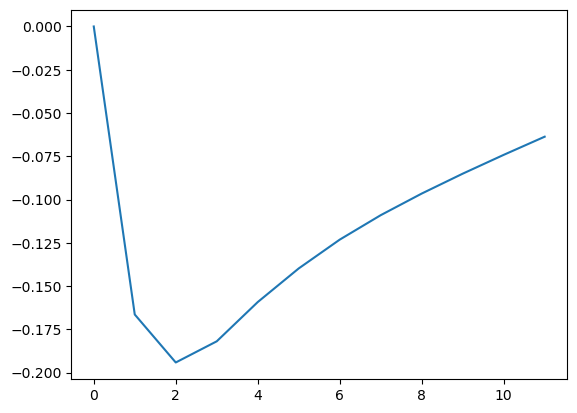

In [10]:
plt.plot(statistics['mean_item_bias'])
print(statistics['mean_item_bias'])